In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from scipy.stats import randint, uniform, f_oneway
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


/Users/brianmiller/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Exploratory Data Analysis
  - No missing data
  - All predictor variables are numerical
### Explore predictor variable distributions & relationships between predictor and outcome variables
  - All predictor variable distributions look acceptable, no data gaps, data looks clean
  - Some variables look to be positively and negatively correlated with score
### Run and ANOVA to determine if any variables are particularly important
  - Alcohol: Has the highest F-value and a very low p-value, indicating it is highly significant in explaining the variation in wine quality.
  - Volatile Acidity, Total Sulfur Dioxide, Sulphates, Citric Acid, Density, Fixed Acidity, Chlorides, Free Sulfur Dioxide, and pH: Also show significance with p-values much lower than 0.05, suggesting that they are statistically significant in explaining wine quality.
  - Residual Sugar: Has an F-value and a p-value that indicates it is not statistically significant


In [3]:
# Load the data
wine_data = pd.read_csv("winequality-red.csv")

In [4]:
# Displaying the data types of each variable in the wine_data DataFrame
data_types = wine_data.dtypes
print(data_types)

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


In [5]:
# Check for NA values in the data
na_count = wine_data.isna().sum().sum()

# Group the quality scores
# This simplifies the classification problem and balances the number of outcomes
wine_data['quality_grouped'] = wine_data['quality'].replace([3, 4, 5], 'bad(3-5)').replace([6, 7, 8], 'good(6-8)')

# Convert the grouped quality scores to a categorical type
wine_data['quality_grouped'] = wine_data['quality_grouped'].astype('category')

# Print the number of NA values and display the first few rows of the modified DataFrame
print("Number of NA values:", na_count)
wine_data.head()

Number of NA values: 0


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_grouped
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,bad(3-5)
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,bad(3-5)
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,bad(3-5)
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,good(6-8)
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,bad(3-5)


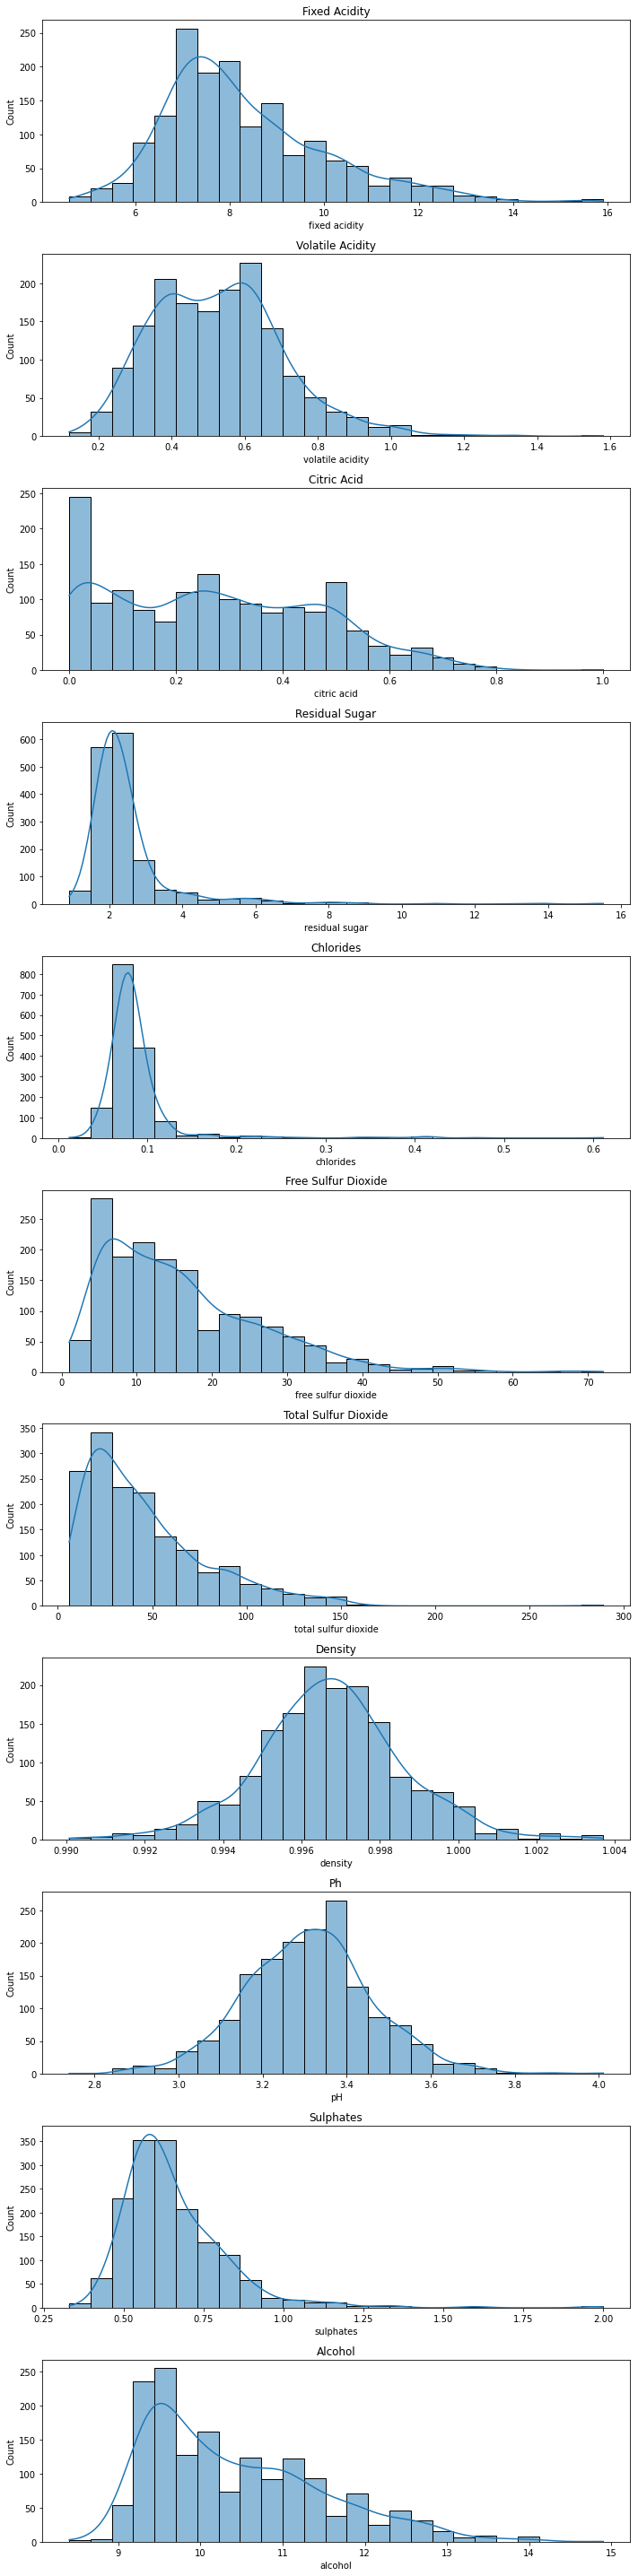

In [6]:
# List of variables to plot
variables_to_plot = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                     'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                     'pH', 'sulphates', 'alcohol']

# Set up the matplotlib figure
fig, axs = plt.subplots(nrows=len(variables_to_plot), ncols=1, figsize=(10, 40))

# Plot each variable
for i, var in enumerate(variables_to_plot):
    sns.histplot(wine_data[var], bins=25, kde=True, ax=axs[i])
    axs[i].set_title(var.replace('_', ' ').title())

# Adjust layout
plt.tight_layout()
plt.show()


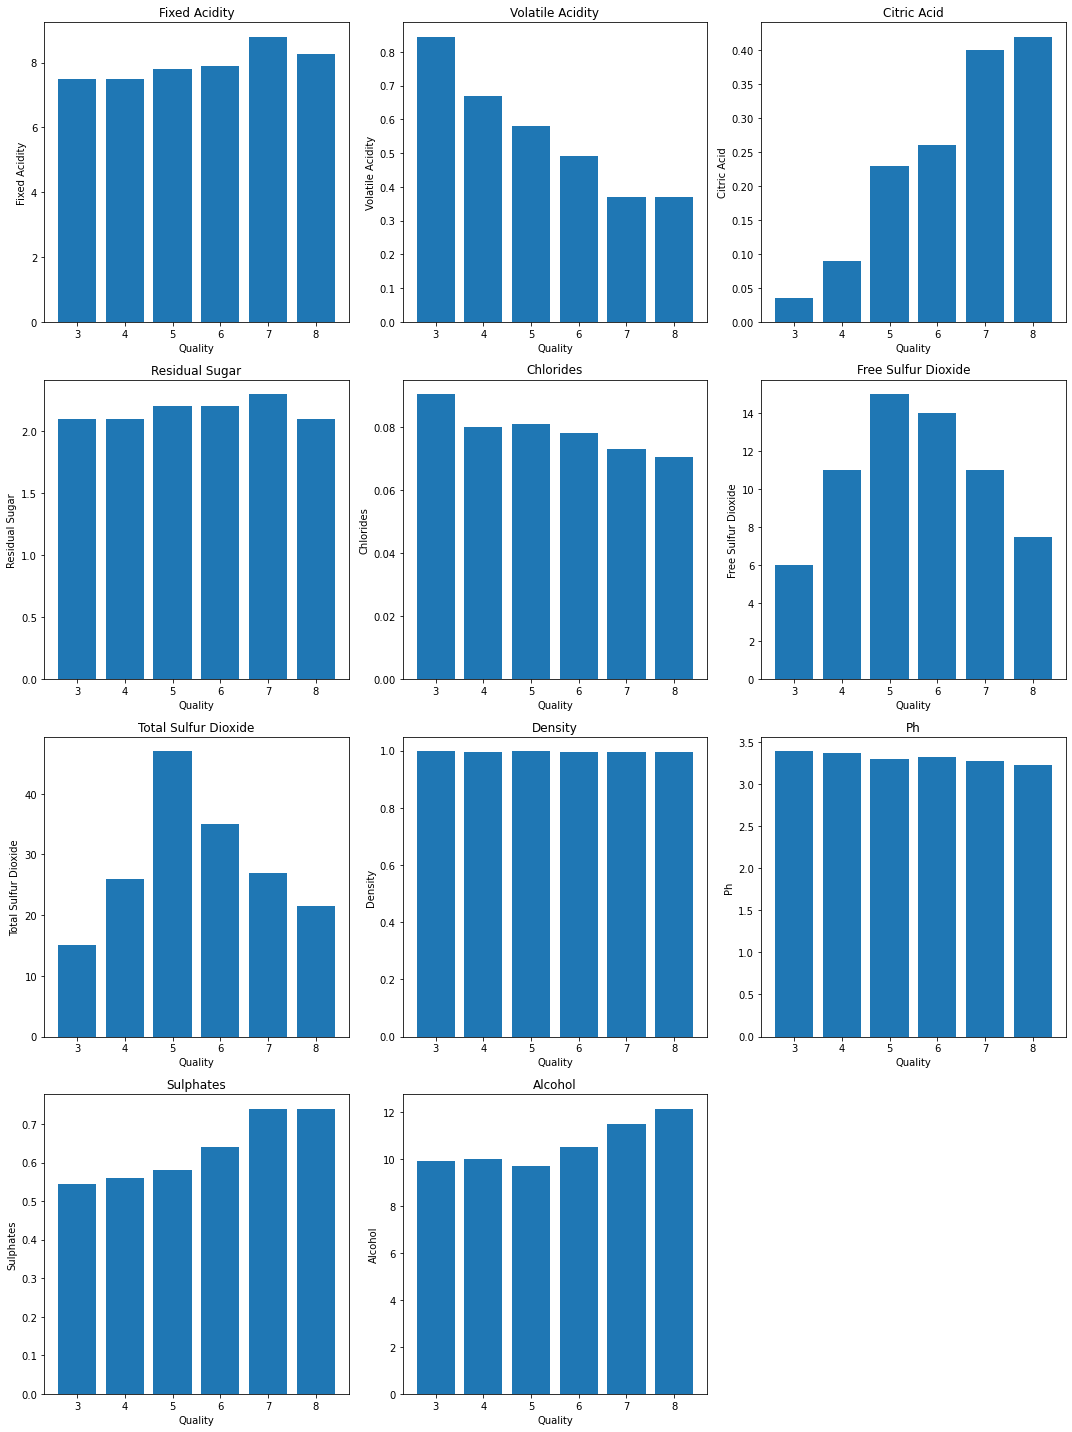

In [7]:
# Aggregate the data by quality
wine_data_agg = wine_data.groupby('quality').median().reset_index()

# List of variables for plotting
variables_to_plot = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                     'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                     'pH', 'sulphates', 'alcohol']

# Set up the matplotlib figure
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# Plot each variable
for i, var in enumerate(variables_to_plot):
    row, col = divmod(i, 3)
    axs[row, col].bar(wine_data_agg['quality'], wine_data_agg[var])
    axs[row, col].set_title(var.replace('_', ' ').title())
    axs[row, col].set_xlabel('Quality')
    axs[row, col].set_ylabel(var.replace('_', ' ').title())

# Hide the empty subplot (if any)
if len(axs.flatten()) > len(variables_to_plot):
    for ax in axs.flatten()[len(variables_to_plot):]:
        ax.set_visible(False)

plt.tight_layout()
plt.show()


In [8]:
# Performing ANOVA for each variable against quality
anova_results = {}
for var in wine_data.columns.drop(['quality', 'quality_grouped']):
    grouped_data = [group[var].values for name, group in wine_data.groupby('quality')]
    f_val, p_val = f_oneway(*grouped_data)
    anova_results[var] = {'F-value': f_val, 'p-value': p_val}

# Convert the ANOVA results dictionary to a DataFrame for better visualization
anova_df = pd.DataFrame(anova_results).transpose()

# Optionally, sort the DataFrame by p-value for easier interpretation
anova_df_sorted = anova_df.sort_values(by='p-value')

# Display the sorted DataFrame
print(anova_df_sorted)


                         F-value        p-value
alcohol               115.854797  1.209895e-104
volatile acidity       60.913993   3.326465e-58
total sulfur dioxide   25.478510   8.533598e-25
sulphates              22.273376   1.225890e-21
citric acid            19.690664   4.421092e-19
density                13.396357   8.124395e-13
fixed acidity           6.283081   8.793967e-06
chlorides               6.035639   1.526539e-05
free sulfur dioxide     4.754233   2.570827e-04
pH                      4.341764   6.284389e-04
residual sugar          1.053374   3.846188e-01


# Prepare Data for Model Building
  - Outcome variable is wine quality scores, binned into groups 'bad' (3,4,5), and good (6,7,8)

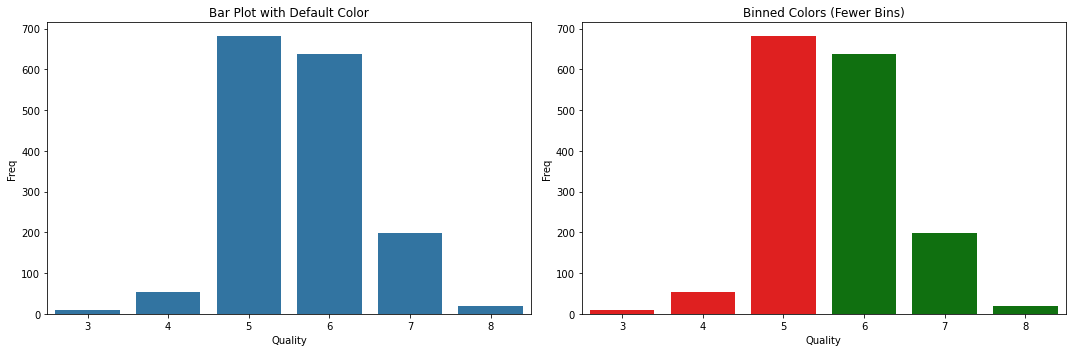

In [9]:
# Count the frequencies of the different quality scores
quality_counts = wine_data['quality'].value_counts().sort_index().reset_index()
quality_counts.columns = ['Quality', 'Freq']

# Setting up the color schemes
colors1 = ["#1f77b4"] * len(quality_counts)  # Default color
colors4 = ["red", "red", "red", "green", "green", "green"][:len(quality_counts)]  # Binned colors with fewer bins

# Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Single row with two columns

# Plot 1: Bar Plot with Default Color
sns.barplot(x='Quality', y='Freq', data=quality_counts, ax=axs[0], palette=colors1)
axs[0].set_title('Bar Plot with Default Color')

# Plot 4: Binned Colors (Fewer Bins)
sns.barplot(x='Quality', y='Freq', data=quality_counts, ax=axs[1], palette=colors4)
axs[1].set_title('Binned Colors (Fewer Bins)')

plt.tight_layout()
plt.show()


In [10]:
wine_data['quality_encoded'] = wine_data['quality_grouped'].replace({'bad(3-5)': 0, 'good(6-8)': 1})

# Features and target variable
X = wine_data.drop(['quality', 'quality_grouped','quality_encoded'], axis=1)
y = wine_data['quality_encoded']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the DataFrame
pd.set_option('display.max_columns', None)  # Replace None with the number of columns you want to display
pd.set_option('display.max_rows', 10)       # Adjust as per your preference
pd.set_option('display.width', 1000)        # Expand display width to avoid line wrapping
pd.set_option('display.float_format', '{:,.2f}'.format)  # Format the float numbers
X_train


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
745,7.30,0.51,0.18,2.10,0.07,12.00,28.00,1.00,3.52,0.73,9.50
823,6.70,0.54,0.13,2.00,0.08,15.00,36.00,1.00,3.61,0.64,9.80
983,9.10,0.50,0.30,1.90,0.07,8.00,17.00,1.00,3.32,0.71,10.50
1505,6.70,0.76,0.02,1.80,0.08,6.00,12.00,1.00,3.55,0.63,9.95
1399,7.20,0.67,0.00,2.20,0.07,10.00,24.00,1.00,3.42,0.72,11.10
...,...,...,...,...,...,...,...,...,...,...,...
20,8.90,0.22,0.48,1.80,0.08,29.00,60.00,1.00,3.39,0.53,9.40
722,7.60,0.42,0.08,2.70,0.08,15.00,48.00,1.00,3.21,0.59,10.00
891,7.20,0.66,0.03,2.30,0.08,16.00,86.00,1.00,3.53,0.57,9.70
1531,6.10,0.70,0.10,2.80,0.08,13.00,28.00,1.00,3.60,0.66,10.20


# Logistic Regression Approach

In [11]:
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')  # You can try solver='saga' if needed
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)

# Evaluation
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)


F1 Score: 0.7522388059701494
Accuracy: 0.740625
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       149
           1       0.77      0.74      0.75       171

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.74      0.74      0.74       320



# Naive Bayes Approach

In [12]:
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Naive Bayes model
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_scaled, y_train)

# Predictions
y_pred_nb = nb_classifier.predict(X_test_scaled)

# Evaluation
f1_nb = f1_score(y_test, y_pred_nb)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
class_report_nb = classification_report(y_test, y_pred_nb)

print(f"F1 Score: {f1_nb}")
print(f"Accuracy: {accuracy_nb}")
print("Classification Report for Naive Bayes:")
print(class_report_nb)


F1 Score: 0.7227414330218069
Accuracy: 0.721875
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       149
           1       0.77      0.68      0.72       171

    accuracy                           0.72       320
   macro avg       0.72      0.73      0.72       320
weighted avg       0.73      0.72      0.72       320



# Random Forest Approach

In [14]:
# Suppress unneeded output and warnings
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 100],  # Number of trees
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of variables to consider per branch
    'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]  # Min number of observations in terminal nodes
}

# Create the GridSearchCV object
rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                       param_grid=param_grid, 
                       cv=5,  # 5-fold cross-validation
                       n_jobs=-1)  # Use all processors

# Fit the grid search to the data
rf_grid.fit(X_train, y_train)

# Best parameters found
best_params = rf_grid.best_params_

# Evaluating the best model
best_model = rf_grid.best_estimator_
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)


# print the results
print("Random Forest Results:")
print("\nBest Hyperparameters from GridSearch:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print("\nBest Test Accuracy from Random Forest GridSearch: {}".format(accuracy_best))
print(f"Best Test F1 Score from Random Forest GridSearch: {f1_best:.4f}")

Random Forest Results:

Best Hyperparameters from GridSearch:
  max_features: auto
  min_samples_leaf: 1
  n_estimators: 300

Best Test Accuracy from Random Forest GridSearch: 0.809375
Best Test F1 Score from Random Forest GridSearch: 0.8190


# XGBoost Approach

In [15]:
# Initialize XGBoost Classifier with basic parameters for RandomizedSearch
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Suppress unneeded output and warnings
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')

# Define a parameter distribution
param_distributions = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 6),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 0.1),
    'reg_lambda': uniform(1, 0.2)
}

# Store the results
iterative_results = []

# Perform RandomizedSearch
for i in range(10):  # Adjust the range for more iterations
    xgb_random = RandomizedSearchCV(xgb_clf, param_distributions, n_iter=10, cv=3, n_jobs=-1)
    xgb_random.fit(X_train, y_train)

    # Retrieve the best parameters and the corresponding best XGBoost model
    best_params_iter = xgb_random.best_params_
    best_xgb_model_iter = xgb_random.best_estimator_

    # Predictions and evaluations
    y_pred_best_iter = best_xgb_model_iter.predict(X_test)
    accuracy_best_iter = accuracy_score(y_test, y_pred_best_iter)
    f1_best_iter = f1_score(y_test, y_pred_best_iter)
    conf_matrix_best_iter = confusion_matrix(y_test, y_pred_best_iter)

    iterative_results.append({
        'iteration': i + 1,
        'best_params': best_params_iter,
        'best_accuracy': accuracy_best_iter,
        'best_f1_score': f1_best_iter,
        'best_confusion_matrix': conf_matrix_best_iter,
        'best_model': best_xgb_model_iter
    })

# Identify the best overall result
best_overall_result = max(iterative_results, key=lambda x: x['best_accuracy'])

# Output the best overall result
print("Best Hyperparameters from RandomizedSearch:")
for param, value in best_overall_result['best_params'].items():
    print(f"  {param}: {value}")
print(f"\nBest Model Test Accuracy from RandomizedSearch: {best_overall_result['best_accuracy']:.4f}")
print(f"Best Model Test F1 Score from RandomizedSearch: {best_overall_result['best_f1_score']:.4f}")

Best Hyperparameters from RandomizedSearch:
  colsample_bytree: 0.7388968771497267
  gamma: 0.3657542640623463
  learning_rate: 0.09626607529765524
  max_depth: 8
  min_child_weight: 1
  n_estimators: 280
  reg_alpha: 0.08419401607577855
  reg_lambda: 1.0578969716825262
  subsample: 0.737802958278525

Best Model Test Accuracy from RandomizedSearch: 0.8531
Best Model Test F1 Score from RandomizedSearch: 0.8597


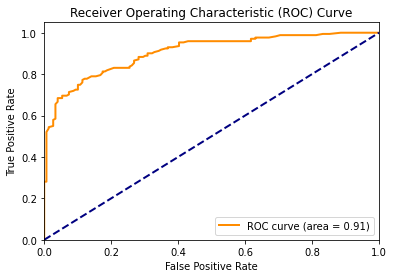

In [13]:
# ROC Curve Plot

# Get the best model from the param search
best_model = best_overall_result['best_model']

# Calculate the probabilities of each class
y_prob = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

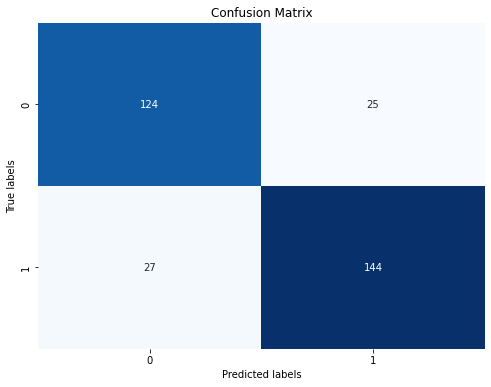

In [16]:
# Assuming you have your test predictions in y_pred_best_iter
conf_matrix = confusion_matrix(y_test, y_pred_best_iter)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


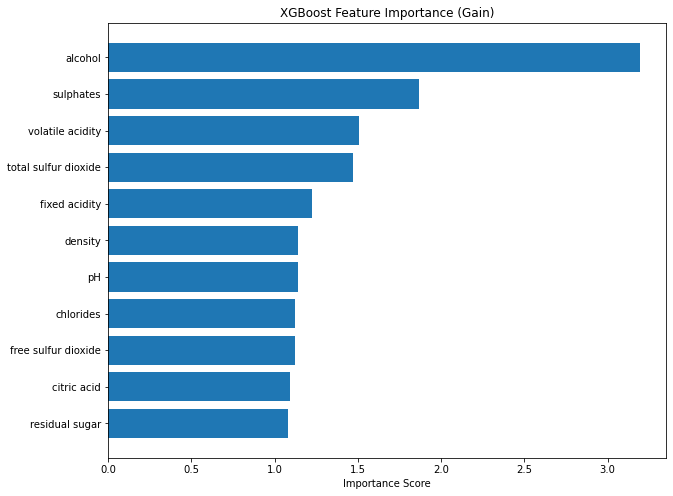

In [18]:
# Get feature importances based on gain
feature_importance_gain = best_xgb_model_iter.get_booster().get_score(importance_type='gain')

# Sort features by their importance
sorted_features = sorted(feature_importance_gain.items(), key=lambda x: x[1], reverse=True)

# Separate the feature names and their importance scores
features, importance_scores = zip(*sorted_features)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(features)), importance_scores, align='center')
plt.yticks(range(len(features)), features)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.xlabel('Importance Score')
plt.title('XGBoost Feature Importance (Gain)')
plt.show()


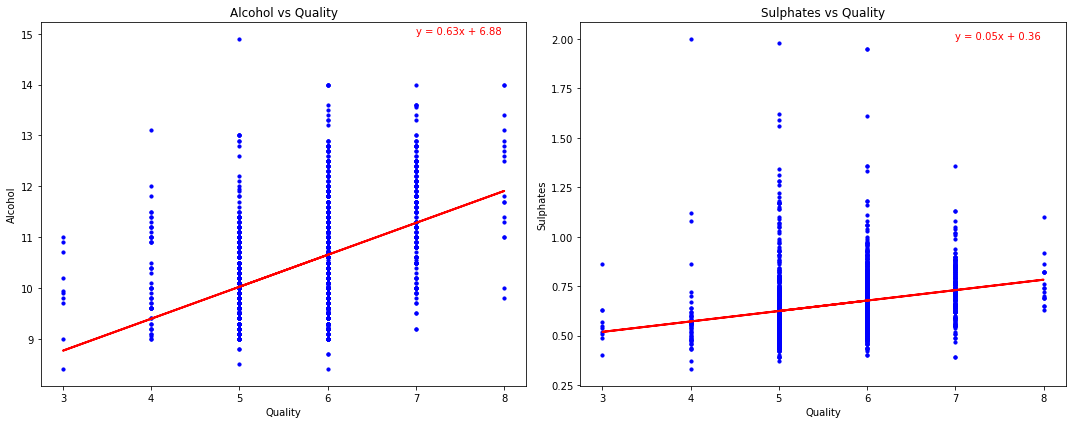

In [19]:
# Function to perform linear regression and return slope and intercept
def linear_regression(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

# Alcohol vs Quality
slope_alc, intercept_alc = linear_regression(wine_data['quality'], wine_data['alcohol'])
wine_data['alcohol_pred'] = intercept_alc + slope_alc * wine_data['quality']

# Volatile Acidity vs Quality
slope_acidity, intercept_acidity = linear_regression(wine_data['quality'], wine_data['sulphates'])
wine_data['sulphates_pred'] = intercept_acidity + slope_acidity * wine_data['quality']

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Alcohol vs Quality
axs[0].scatter(wine_data['quality'], wine_data['alcohol'], color='blue', s=10)
axs[0].plot(wine_data['quality'], wine_data['alcohol_pred'], color='red', linewidth=2)
axs[0].set_xlabel('Quality')
axs[0].set_ylabel('Alcohol')
axs[0].set_title('Alcohol vs Quality')
axs[0].text(7, 15, 'y = {:.2f}x + {:.2f}'.format(slope_alc, intercept_alc), color='red')

# Volatile Acidity vs Quality
axs[1].scatter(wine_data['quality'], wine_data['sulphates'], color='blue', s=10)
axs[1].plot(wine_data['quality'], wine_data['sulphates_pred'], color='red', linewidth=2)
axs[1].set_xlabel('Quality')
axs[1].set_ylabel('Sulphates')
axs[1].set_title('Sulphates vs Quality')
axs[1].text(7, 2, 'y = {:.2f}x + {:.2f}'.format(slope_acidity, intercept_acidity), color='red')

plt.tight_layout()
plt.show()